In [10]:
import time
import logging
import sys
import gzip

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.signal import savgol_filter

from collections import Counter

from scipy import stats
def r(x, y):
    return stats.pearsonr(x, y)[0]

%matplotlib inline

samples = ['ky11', 'ky13']
#samples = ['ky17', 'ky18', 'ky11', 'ky13']

pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 5

In [11]:
#load in preprocessed mnetseq dfs
dfs = []

for i, x in enumerate(samples):
    df = pd.read_csv('data_2021-08-27/'+x+'/'+x+'_info.new.clean.gtf')
    print(i)
    dfs.append(df)

0
1


In [67]:
for df in dfs:
    print(len(df))

18140416
8786470


In [12]:
#load in hotspots
lorax_sigs = []

for i, x in enumerate(samples):
    df = pd.read_csv('data_2021-08-27/'+x+'/hotspots.new.clean.gtf')
    print(i)
    lorax_sigs.append(df)

0
1


In [13]:
#clean data

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    clean_dfs.append(cdf)

18140416
8786470


In [50]:
#clean data - run to drop duplicates

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    print(len(cdf))
          
    cdf = cdf.drop_duplicates(['5prime', '3prime'])
    
    print(len(cdf))
          
    clean_dfs.append(cdf)

33457091
24103950
18618182
42318663
31091610
24130895


In [14]:
#find cross-correlation

df1 = clean_dfs[0] 
df2 = clean_dfs[1] #fix the ko and shift wt

genelens = df1[df1.gene_type == 'protein_coding'].drop_duplicates('gene_name')
genelens = genelens[['gene_name', 'gene_start', 'gene_end', 'gene_strand']]

df1 = df1[df1.gene_type == 'protein_coding'].groupby(['gene_name', '3prime']).size()
df2 = df2[df2.gene_type == 'protein_coding'].groupby(['gene_name', '3prime']).size()

In [15]:
genelens['gene_len'] = genelens.gene_end - genelens.gene_start

In [16]:
#get rpkm table
g = df1.groupby('gene_name').size().reset_index()
g.iloc[:, 1] = (g.iloc[:, 1] * 1E6 / sum(g.iloc[:, 1]))
g = g.merge(genelens, on='gene_name')
g.iloc[:, 1] = g.iloc[:, 1] / (g.gene_len / 1000)

g = g[~g.gene_name.str.contains('MT-')]
g = g[g.gene_len > 60]

In [17]:
filt = g.sort_values(0,ascending=False).gene_name[0:1000]
len(filt)

1000

In [18]:
xcorrsvs = []
xcorrswt = []


count = 0
for gene in filt:
    #print(gene)
    if gene in df1 and gene in df2:

        a = df1[gene].reset_index()
        b = df2[gene].reset_index()

        genestart = genelens[genelens.gene_name == gene].gene_start.iloc[0]
        geneend = genelens[genelens.gene_name == gene].gene_end.iloc[0]
        genelen = geneend-genestart
        genestrand = genelens[genelens.gene_name == gene].gene_strand.iloc[0]


        print(gene + ' ' + str(count))
        count += 1

        filled = pd.DataFrame(range(genestart, geneend), columns=['3prime']).merge(a, on='3prime', how='outer').merge(b, on='3prime', how='outer').fillna(0)

        #run xcorr loop

        arr1 = filled['0_x']
        arr2 = filled['0_y'][30:-31]

        xcorr = []
        for i in range(30, -31, -1):
            xcorr.append(r(arr1[30+i:-31+i], arr2))

        if genestrand == '-':
            xcorr.reverse()
        xcorrsvs.append(np.array(xcorr))



        filled = pd.DataFrame(range(genestart, geneend), columns=['3prime']).merge(a, on='3prime', how='outer').merge(a, on='3prime', how='outer').fillna(0)

        arr1 = filled['0_x']
        arr2 = filled['0_y'][30:-31]

        xcorr = []
        for i in range(30, -31, -1):
            xcorr.append(r(arr1[30+i:-31+i], arr2))

        if genestrand == '-':
            xcorr.reverse()
        xcorrswt.append(np.array(xcorr))


H3C2 0
H1-4 1
H1-2 2
H2AC12 3
H2BC12 4
H4C3 5
HIST1H4B 6
CTD-2252G20.1 7
DDIT4 8
IRS4 9
RPL41 10
ATF4 11
JUN 12
H3C1 13
RPL10A 14
RP11-397P13.9 15
H2AC20 16


/home/kevin/miniconda3/envs/py3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ADAMTS1 17
H2AC21 18
H2BC17 19
RPL3 20
PNN 21
NDUFB10 22
DDX5 23
NOP56 24
ID3 25
RHOB 26
EIF1 27
EEF2 28
H2AC13 29
HEY1 30
H4C5 31
SRRM2 32
RPS2 33
MAT2A 34
RTL8C 35
RP11-318A15.7 36
DDX17 37
RPL13 38
RPS27 39
HNRNPU 40
RPS6 41
SFPQ 42
CKB 43
RPL12 44
H3C10 45
TXNIP 46
RABGGTB 47
GADD45B 48
HNRNPDL 49
RPS11 50
H2AX 51
H2AC7 52
RPL8 53
RPL7A 54
RPLP1 55
RPS16 56
H1-0 57
RPS21 58
HSP90AB1 59
H1-3 60
H2AC11 61
FTL 62
C6orf226 63
STUB1 64
RPS15 65
PMAIP1 66
RPL13A 67
TMSB10 68
AP000471.4 69
SAT1 70
SEPHS2 71
ID2 72
HES4 73
TUBB4B 74
ZNF703 75
H4C1 76
RPS12 77
JUND 78
H2AW 79
RPL23 80
H4C4 81
RPLP0 82
EIF4A2 83
RPS25 84
COX20 85
IMPDH2 86
RP11-18C24.9 87
FUS 88
CALR 89
HNRNPAB 90
RPS8 91
TLCD1 92
SOX4 93
FOXC1 94
RPL18 95
RACK1 96
H2AC19 97
H2BC21 98
RPL29 99
RPL32 100
HSPA5 101
HES1 102
H3C13 103
RP11-159D12.5 104
MRPS34 105
H2AC8 106
RPL19 107
SRSF7 108
RPSA 109
HSPA8 110
PTMA 111
RPL38 112
PPP1R15A 113
RPL27 114
H2AC15 115
SNX5 116
RPL37 117
MKI67 118
HNRNPH1 119
RPL11 120
RPS19 121
H3C7

COMTD1 823
CCDC71 824
MRPL40 825
TARS1 826
PNKP 827
C2orf68 828
C22orf15 829
CCT8 830
RP11-182N22.10 831
MRPS21 832
NDUFV1 833
MYBBP1A 834
TUSC1 835
LENG1 836
NAT9 837
PTMS 838
COA3 839
AEN 840
SCD 841
NDUFB11 842
UBR4 843
SLC37A4 844
SLC39A1 845
CDIPT 846
TMEM259 847
ZDHHC16 848
PIP4P1 849
MICOS13 850
NDUFA13 851
REX1BD 852
QARS1 853
FRAT2 854
IL18BP 855
VAMP2 856
INSIG1 857
KCTD12 858
E2F3 859
ATRAID 860
SHARPIN 861
TSPAN31 862
LMF2 863
HNRNPM 864
GEMIN4 865
LUC7L2 866
SAFB2 867
AMIGO3 868
ADNP 869
RBM12B 870
ELOB 871
TUBG1 872
ZIC5 873
FNBP4 874
CRKL 875
SARS1 876
PSMC4 877
PARP1 878
TTC19 879
UQCRH 880
ARL4C 881
PPDPF 882
ZNF276 883
RP11-807C20.3 884
BAP1 885
COASY 886
GLT8D1 887
TM7SF2 888
TMEM147 889
CCAR1 890
PURB 891
CPNE1 892
ALKBH2 893
NELFCD 894
TRMT2A 895
MAGED2 896
ARRB2 897
SNRPD2 898
MCL1 899
SPAG4 900
IRF3 901
RBM25 902
MLST8 903
FBXW5 904
PIGY 905
AL353354.1 906
CDC45 907
SMARCD2 908
TIGD1 909
GLO1 910
CDC25A 911
FDPS 912
CCNG1 913
MRFAP1L1 914
TMUB2 915
CH507-9B2.4 91

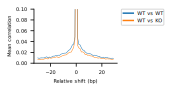

In [25]:
plt.figure(figsize = (1.5, 1))
    

pdf = pd.DataFrame(zip(range(-30, 30), np.nanmean(xcorrswt,axis=0), np.nanmean(xcorrsvs,axis=0)), columns = ['shift', 'WT vs WT', 'WT vs KO'])
ax = sns.lineplot(data=pdf.melt('shift'), x='shift', y='value', hue='variable', lw=.5)

sns.despine()

ax.set_xlabel('Relative shift (bp)')
ax.set_ylabel('Mean correlation')
ax.set_ylim(0, .1)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/lorax_corr_rep.svg', format="svg", dpi=1000)
plt.show()

In [ ]:
#find mnetseq signal around pauses to look for "right shift"

In [20]:
ws = []
ls = []

for j in [0, 1]:

    searchsize = 15
    binsize = 1
    windowsize = int(searchsize/binsize)

    windows = []
    lorax_len = []

    lorax_sig = lorax_sigs[0]
    lorax_sig = lorax_sig[lorax_sig.gene_type == 'protein_coding']
    lorax_sig = lorax_sig[0:100000]
    
    df = clean_dfs[j]
    
    if 'count' not in df:
        df['count'] = 1

    print(len(lorax_sig))

    chrms = lorax_sig.chr_1.unique()

    for chrom in chrms:
        #print(chrom)

        genesc = lorax_sig[(lorax_sig.chr_1 == chrom)].sort_values('3prime')
        dfc = df[(df.chr_1 == chrom)].sort_values('3prime')

        for gene_strand, t, comp_len in zip(genesc.read_strand_1, genesc['3prime'], genesc.comp_len):
            lowerb = t - searchsize
            upperb = t + searchsize

            nets = dfc['3prime']
            nets_e = dfc['3prime'] + 1
            nets_strand = dfc['read_strand_1']
            counts = dfc['count']

            start = np.searchsorted(nets, lowerb)
            end = np.searchsorted(nets_e, upperb)

            window = [0] * searchsize*2

            for net, net_e, net_strand, count in zip(nets[start:end], nets_e[start:end], nets_strand[start:end], counts[start:end]):
                if net_strand == gene_strand:
                    if (lowerb < net) and (net_e < upperb):
                        for k in range(net-lowerb, net_e-lowerb):

                            if net_strand == '-':
                                k = searchsize*2 - k
                            window[k] += count

            windows.append(window)
            lorax_len.append(comp_len)

    w = np.array(windows)
    ws.append(w)
    
    l = np.array(lorax_len)
    ls.append(l)

100000
100000


In [21]:
labels = ['wt', 'ko']

bs = []

for i, (w, l) in enumerate(zip(ws, ls)):

    neww = []
    for wa in w:
        neww.append(stats.zscore(wa))
    w = neww

    bs.append(w)

In [22]:
wt = pd.DataFrame(bs[0]).T
wt.columns = ['WT'] * len(bs[0])

ko = pd.DataFrame(bs[1]).T
ko.columns = ['KO'] * len(bs[1])

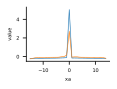

In [23]:
pdf = wt.join(ko)

pdf['xa'] = list(range(-windowsize, windowsize))

plt.figure(figsize = (1.5, 1))

ax = sns.lineplot(x='xa', y='value', hue='variable', data=pdf.melt('xa'), lw=.5)
#ax.set_xlim(-searchsize+1, searchsize-1)
sns.despine()

plt.legend().remove()

plt.savefig('svg/wt_concordance_rep.svg', format="svg", dpi=1000)
plt.show()

In [30]:
diffsup = []
diffsdown = []

for i in range(len(bs[0])):
    a = np.nanmean(bs[1][i][16:])
    b = np.nanmean(bs[0][i][16:])

    diffsup.append(a-b)

    a = np.nanmean(bs[1][i][:14])
    b = np.nanmean(bs[0][i][:14])

    diffsdown.append(a-b)


/tmp/ipykernel_3678567/1305197926.py:5: RuntimeWarning: Mean of empty slice
  a = np.nanmean(bs[1][i][16:])
/tmp/ipykernel_3678567/1305197926.py:10: RuntimeWarning: Mean of empty slice
  a = np.nanmean(bs[1][i][:14])


In [31]:
diffswt = []
diffsko = []

for i in range(len(bs[0])):
    a = np.nanmean(bs[0][i][:14])
    b = np.nanmean(bs[0][i][16:])

    diffswt.append(b-a)

    a = np.nanmean(bs[1][i][:14])
    b = np.nanmean(bs[1][i][16:])

    diffsko.append(b-a)


/tmp/ipykernel_3678567/852586039.py:10: RuntimeWarning: Mean of empty slice
  a = np.nanmean(bs[1][i][:14])
/tmp/ipykernel_3678567/852586039.py:11: RuntimeWarning: Mean of empty slice
  b = np.nanmean(bs[1][i][16:])


In [32]:
print(len([i for i in diffswt if i > 0])/len(diffswt))

print(len([i for i in diffsko if i > 0])/len(diffsko))

print(len([i for i in diffsko if i > 0])/len(diffsko) - len([i for i in diffswt if i > 0])/len(diffswt))

0.50897
0.56714
0.058169999999999944


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


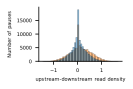

In [33]:
pdf = pd.DataFrame(zip(diffswt, diffsko), columns=['WT', 'KO'])

plt.figure(figsize = (1.5, 1))

ax = sns.histplot(data=pdf.melt(), x='value', hue='variable', bins=50)
sns.despine()
#ax.set_yscale('log')
#ax.set_xlim(-100, 100)


ax.set_ylabel('Number of pauses')
ax.set_xlabel('upstream-downstream  read density')

plt.legend().remove()
plt.savefig('svg/btindex.svg', format="svg", dpi=1000)
plt.show()